# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда.



In [ ]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)

    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3,
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2, drop_last=True)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, drop_last=True)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2, drop_last=True)

    return train_loader, val_loader, test_loader


In [ ]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64,
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

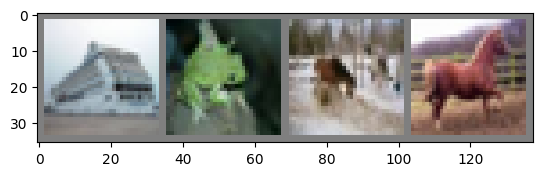

ship frog horse horse


In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [ ]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, 3, padding= 1)
        self.conv2 = nn.Conv2d(3, 32, 1, 1)
        self.h_conv = nn.Conv2d(32, 32, 1)
        self.norm = nn.BatchNorm2d(32)
        self.avgPool = nn.AvgPool2d(7)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        out = self.conv(x)
        x = self.conv2(x)
        out = self.norm(out)
        out = self.relu(out)
        out = self.h_conv(out)
        out = self.norm(out)
        out += x
        out = self.relu(out)
        out = self.avgPool(out)
        out = out.flatten(1)
        out = self.fc(out)

        return out

In [ ]:
net = BasicBlockNet()
net

BasicBlockNet(
  (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1))
  (h_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (avgPool): AvgPool2d(kernel_size=7, stride=7, padding=0)
  (relu): ReLU()
  (fc): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [ ]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [ ]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [ ]:
criterion = nn.CrossEntropyLoss()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    for data, target in loader:
      data = data.to(device)
      target = target.to(device)
      targetV = torch.zeros((64, 10)).to(device)
      targetV.scatter_(1, target.view(-1, 1).long(), 1)
      with torch.no_grad():
        predict = model(data)
        loss = criterion(predict, targetV)

      loss_log.append(loss.item())

      acc = torch.sum(target == torch.argmax(predict, dim=1))/target.shape[0]

      acc_log.append(acc.item())

    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)
        targetV = torch.zeros((64, 10)).to(device)
        targetV.scatter_(1, target.view(-1, 1).long(), 1)
        optimizer.zero_grad()
        predict = model(data)
        loss = criterion(predict, targetV)
        loss.backward()
        optimizer.step()
        loss_log.append(loss.item())
        acc = torch.sum(target ==  torch.argmax(predict, dim=1))/target.shape[0]
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)

        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, train_loader, val_loader)

Epoch 0
 train loss: 1.492741306513657, train acc: 0.4654876373626374
 val loss: 1.4643355475531683, val acc: 0.48223824786324787

Epoch 1
 train loss: 1.2391349423281002, train acc: 0.5645890567765568
 val loss: 1.6526151187399514, val acc: 0.41760149572649574

Epoch 2
 train loss: 1.1409544206800915, train acc: 0.6017628205128205
 val loss: 1.8722529095462246, val acc: 0.37319711538461536

Epoch 3
 train loss: 1.0816735902548709, train acc: 0.6238839285714286
 val loss: 2.025471448388874, val acc: 0.35510149572649574

Epoch 4
 train loss: 1.0529164495048942, train acc: 0.6371336996336996
 val loss: 1.8467405214268937, val acc: 0.3783386752136752

Epoch 5
 train loss: 1.0218463007347052, train acc: 0.6446886446886447
 val loss: 1.8214578047776833, val acc: 0.34915865384615385

Epoch 6
 train loss: 1.0025053172757774, train acc: 0.6529304029304029
 val loss: 1.7941900557941861, val acc: 0.3401442307692308

Epoch 7
 train loss: 0.9886987734408605, train acc: 0.6552197802197802
 val loss

In [ ]:
print(val_loss_log[:2])

[1.4643355475531683, 1.6526151187399514]


Посчитайте точность на тестовой выборке:

In [ ]:
test(net, test_loader)

(2.2246919878018208, 0.2675280448717949)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

In [ ]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    fig, axs = plt.subplots(2, 2, figsize=(15, 5))
    axs[0, 0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[1, 0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0,1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1,1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    for ax1, ax2 in axs:
        ax1.set_xlabel('epoch')
        ax1.legend()
        ax2.set_xlabel('epoch')
        ax2.legend()

    axs[0, 0].set_ylabel('loss')
    axs[0, 1].set_ylabel('Accuracy')
    plt.show()

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

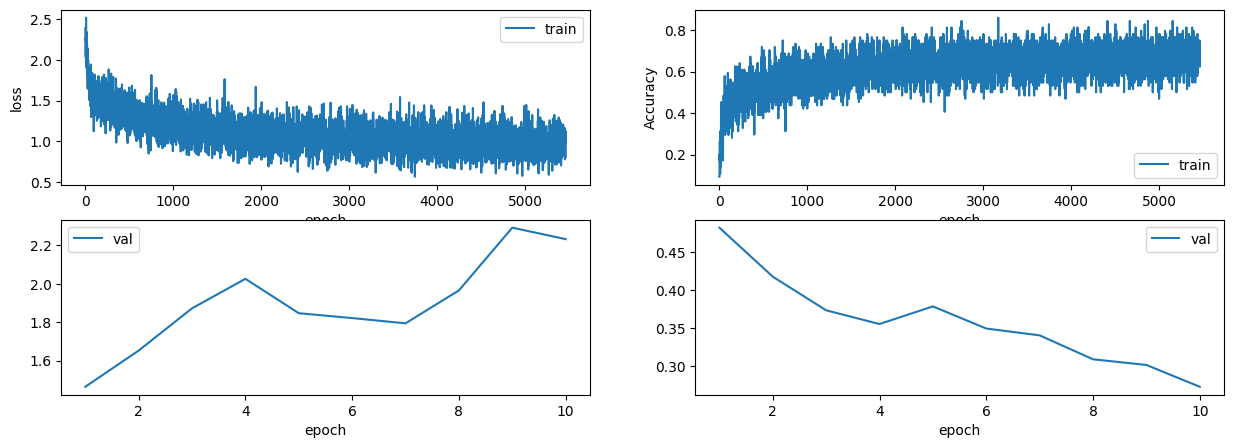

In [ ]:
plot_losses(train_loss_log, train_acc_log, val_loss_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5159906076860952, train acc: 0.4558150183150183
 val loss: 1.835571208061316, val acc: 0.38514957264957267

Epoch 1
 train loss: 1.2886590420544803, train acc: 0.5435267857142857
 val loss: 1.7940540400325742, val acc: 0.39623397435897434

Epoch 2
 train loss: 1.193786077556156, train acc: 0.5818738553113553
 val loss: 1.8076807535611665, val acc: 0.35877403846153844

Epoch 3
 train loss: 1.1339013521924561, train acc: 0.6021062271062271
 val loss: 2.0818943799051466, val acc: 0.273838141025641

Epoch 4
 train loss: 1.0937159815769055, train acc: 0.6167296245421245
 val loss: 2.1766075593793492, val acc: 0.26469017094017094

Epoch 5
 train loss: 1.0613615875279074, train acc: 0.6294070512820513
 val loss: 2.90213258144183, val acc: 0.2093349358974359

Epoch 6
 train loss: 1.0306730080436874, train acc: 0.6413118131868132
 val loss: 2.5383735436659594, val acc: 0.21955128205128205

Epoch 7
 train loss: 1.0163437095317212, train acc: 0.646978021978022
 val loss: 2.

Посчитайте точность на тестовой выборке:

In [ ]:
test(net, test_loader)

(2.8405769986984057, 0.23517628205128205)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, train_loader, val_loader)

Epoch 0
 train loss: 1.867533191219791, train acc: 0.3507039835164835
 val loss: 1.8520009665407686, val acc: 0.3072916666666667

Epoch 1
 train loss: 1.581260308677897, train acc: 0.44971955128205127
 val loss: 2.0962108307414584, val acc: 0.24913194444444445

Epoch 2
 train loss: 1.4653665674475087, train acc: 0.4866357600732601
 val loss: 2.117167171250042, val acc: 0.26001602564102566

Epoch 3
 train loss: 1.3987287614808415, train acc: 0.509529532967033
 val loss: 2.2189879121943417, val acc: 0.2484642094017094

Epoch 4
 train loss: 1.3523820953054742, train acc: 0.5269288003663004
 val loss: 2.361219609904493, val acc: 0.23130341880341881

Epoch 5
 train loss: 1.319021409247821, train acc: 0.5406936813186813
 val loss: 2.2388661172654896, val acc: 0.25874732905982906

Epoch 6
 train loss: 1.2872780630221734, train acc: 0.5497939560439561
 val loss: 2.3488730039352026, val acc: 0.2543402777777778

Epoch 7
 train loss: 1.253742183084453, train acc: 0.5634729853479854
 val loss: 2.3

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.5356304628071769, train acc: 0.45006295787545786
 val loss: 1.688963104517032, val acc: 0.41139155982905984

Epoch 1
 train loss: 1.2188130433742816, train acc: 0.5716861263736264
 val loss: 1.9829698011406467, val acc: 0.38000801282051283

Epoch 2
 train loss: 1.169750641881328, train acc: 0.5898580586080586
 val loss: 2.130061058407156, val acc: 0.35550213675213677

Epoch 3
 train loss: 1.1632822344809661, train acc: 0.5918612637362637
 val loss: 2.1703163522940416, val acc: 0.34915865384615385

Epoch 4
 train loss: 1.1622244772456942, train acc: 0.5929201007326007
 val loss: 2.138408412790706, val acc: 0.3561698717948718

Epoch 5
 train loss: 1.1615963627348889, train acc: 0.5922046703296703
 val loss: 2.128826412380251, val acc: 0.35436698717948717

Epoch 6
 train loss: 1.162460751040078, train acc: 0.5932062728937729
 val loss: 2.145995604686248, val acc: 0.35523504273504275

Epoch 7
 train loss: 1.1617672792721143, train acc: 0.5935210622710623
 val loss: 2

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=2)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.501881289394784, train acc: 0.4641998626373626
 val loss: 1.9950661852828457, val acc: 0.36725427350427353

Epoch 1
 train loss: 1.203666287245768, train acc: 0.5768372252747253
 val loss: 1.8086400200159123, val acc: 0.3938301282051282

Epoch 2
 train loss: 1.1405940782892836, train acc: 0.6063129578754579
 val loss: 1.7673524281917474, val acc: 0.4015758547008547

Epoch 3
 train loss: 1.143650893544976, train acc: 0.6021348443223443
 val loss: 2.0793485840161643, val acc: 0.36331463675213677

Epoch 4
 train loss: 1.170698690872926, train acc: 0.5922619047619048
 val loss: 2.110751671668811, val acc: 0.34301549145299143

Epoch 5
 train loss: 1.0475248229372633, train acc: 0.6371050824175825
 val loss: 2.241473898418948, val acc: 0.35510149572649574

Epoch 6
 train loss: 0.9975130098424988, train acc: 0.6549622252747253
 val loss: 2.2812047284892483, val acc: 0.34588675213675213

Epoch 7
 train loss: 1.024199488180461, train acc: 0.6443166208791209
 val loss: 3.0

Your answers here:

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

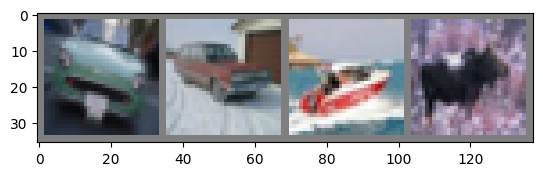

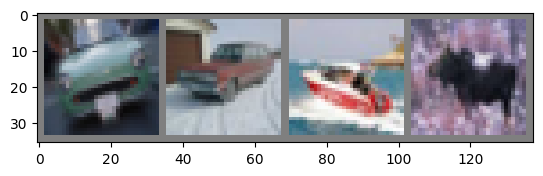

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.508765275661762, train acc: 0.45887706043956045
 val loss: 1.7583317364382947, val acc: 0.37426549145299143

Epoch 1
 train loss: 1.2643423263843243, train acc: 0.5557749542124543
 val loss: 1.5992175304991567, val acc: 0.42354433760683763

Epoch 2
 train loss: 1.1642173722986773, train acc: 0.5922332875457875
 val loss: 1.912650230093899, val acc: 0.31356837606837606

Epoch 3
 train loss: 1.114450066626727, train acc: 0.6132669413919414
 val loss: 1.9154640619571393, val acc: 0.3094951923076923

Epoch 4
 train loss: 1.0775238103045648, train acc: 0.6257154304029304
 val loss: 1.8766318004355471, val acc: 0.3230502136752137

Epoch 5
 train loss: 1.0462206430705911, train acc: 0.6369906135531136
 val loss: 1.8041999864782023, val acc: 0.3236511752136752

Epoch 6
 train loss: 1.0226831378299237, train acc: 0.645260989010989
 val loss: 1.9576388011630783, val acc: 0.29734241452991456

Epoch 

Посчитайте точность на тестовой выборке:

In [ ]:
test(net, test_loader)

(2.0285224425487027, 0.25110176282051283)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [ ]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.RandomVerticalFlip(),
         transforms.RandomRotation([15, 45]),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 10, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.7001082469255497, train acc: 0.3769459706959707
 val loss: 1.8453024350679839, val acc: 0.31650641025641024

Epoch 1
 train loss: 1.5312332172533532, train acc: 0.4440533424908425
 val loss: 2.3773063227661653, val acc: 0.20592948717948717

Epoch 2
 train loss: 1.4561336136562921, train acc: 0.47661973443223443
 val loss: 2.1000783107219596, val acc: 0.234375

Epoch 3
 train loss: 1.39805064031056, train acc: 0.49745306776556775
 val loss: 2.9528792790877514, val acc: 0.16332799145299146

Epoch 4
 train loss: 1.361175381438636, train acc: 0.511647206959707
 val loss: 3.5731786713640914, val acc: 0.18456196581196582

Epoch 5
 train loss: 1.3436501961706322, train acc: 0.5186870421245421
 val loss: 4.254304608728131, val acc: 0.15544871794871795

Epoch 6
 train loss: 1.307658504653763, train acc: 0.534426510989011
 val loss: 5.115105354887808, val acc: 0.16786858974358973

Epoch 7
 train lo

Your answers here:

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [ ]:
# <your code here>